<a href="https://colab.research.google.com/github/Faareh-Ahmed/Cat_and_Dog_Breed_classsification/blob/main/CatAndDogBreed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"faarehahmed","key":"0ea6e7c3d7bd40520a62713a6f982c7c"}'}

In [4]:
! mkdir ~/kaggledata
! cp kaggle.json ~/kaggledata/
! chmod 600 ~/kaggledata/kaggle.json
! kaggle datasets list

mkdir: cannot create directory ‘/root/kaggledata’: File exists
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 398, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [5]:
!kaggle datasets download -d zippyz/cats-and-dogs-breeds-classification-oxford-dataset

Dataset URL: https://www.kaggle.com/datasets/zippyz/cats-and-dogs-breeds-classification-oxford-dataset
License(s): CC-BY-SA-4.0
cats-and-dogs-breeds-classification-oxford-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip cats-and-dogs-breeds-classification-oxford-dataset.zip

Archive:  cats-and-dogs-breeds-classification-oxford-dataset.zip
replace annotations/annotations/._trimaps? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
!pwd

/content


# Downloading the Necessary Libraries

In [8]:
pip install tensorflow --upgrade

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay,confusion_matrix, classification_report,accuracy_score, f1_score


In [10]:
import tensorflow as tf
print(tf.__version__)

2.16.1


In [11]:
IMG_SHAPE = (250,250)
IMG_SHAPE_GN = (250,250,3)

# Reading Annotations Folder to get information about the Data

In [12]:
#reading csv
df = pd.read_csv('/content/annotations/annotations/list.txt')

#The first 4 rows consists of the information about breeds
info = df.head(4).copy()

In [13]:
#Reading the data after 5th row
df = df.loc[5:,]

#Processing the columns
df[['CLASS-ID','SPECIES','BREED','ID']] = df['#Image CLASS-ID SPECIES BREED ID'].str.split(expand=True)

#Dropping unnecessary columns
df = df.drop('#Image CLASS-ID SPECIES BREED ID',axis=1)

#renaming the columns
df = df.rename(columns={"CLASS-ID": "image", "SPECIES": "CLASS-ID", 'BREED' : "SPECIES", "ID":"BREED ID"})


#converting the object type to int type
df[["CLASS-ID","SPECIES","BREED ID"]] = df[["CLASS-ID","SPECIES","BREED ID"]].astype(int)

<ipython-input-13-18b912c3ee20>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['CLASS-ID','SPECIES','BREED','ID']] = df['#Image CLASS-ID SPECIES BREED ID'].str.split(expand=True)
<ipython-input-13-18b912c3ee20>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['CLASS-ID','SPECIES','BREED','ID']] = df['#Image CLASS-ID SPECIES BREED ID'].str.split(expand=True)
<ipython-input-13-18b912c3ee20>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [ ]:
df

image  CLASS-ID  SPECIES  BREED ID
5           Abyssinian_100         1        1         1
6           Abyssinian_101         1        1         1
7           Abyssinian_102         1        1         1
8           Abyssinian_103         1        1         1
9           Abyssinian_104         1        1         1
...                    ...       ...      ...       ...
7349  yorkshire_terrier_96        37        2        25
7350  yorkshire_terrier_97        37        2        25
7351  yorkshire_terrier_98        37        2        25
7352  yorkshire_terrier_99        37        2        25
7353   yorkshire_terrier_9        37        2        25

[7349 rows x 4 columns]

In [14]:
df['image'] = df['image'].apply(lambda x : str(x)+'.jpg')
df = df.reset_index()
df = df.drop('index',axis=1)

In [ ]:
df

image  CLASS-ID  SPECIES  BREED ID
0           Abyssinian_100.jpg         1        1         1
1           Abyssinian_101.jpg         1        1         1
2           Abyssinian_102.jpg         1        1         1
3           Abyssinian_103.jpg         1        1         1
4           Abyssinian_104.jpg         1        1         1
...                        ...       ...      ...       ...
7344  yorkshire_terrier_96.jpg        37        2        25
7345  yorkshire_terrier_97.jpg        37        2        25
7346  yorkshire_terrier_98.jpg        37        2        25
7347  yorkshire_terrier_99.jpg        37        2        25
7348   yorkshire_terrier_9.jpg        37        2        25

[7349 rows x 4 columns]

In [15]:
#Extracting the classname/breed of the animal
df['classname'] = df['image'].apply(lambda x: str(x)[0:str(x).index('_')])


In [ ]:
df

image  CLASS-ID  SPECIES  BREED ID   classname
0           Abyssinian_100.jpg         1        1         1  Abyssinian
1           Abyssinian_101.jpg         1        1         1  Abyssinian
2           Abyssinian_102.jpg         1        1         1  Abyssinian
3           Abyssinian_103.jpg         1        1         1  Abyssinian
4           Abyssinian_104.jpg         1        1         1  Abyssinian
...                        ...       ...      ...       ...         ...
7344  yorkshire_terrier_96.jpg        37        2        25   yorkshire
7345  yorkshire_terrier_97.jpg        37        2        25   yorkshire
7346  yorkshire_terrier_98.jpg        37        2        25   yorkshire
7347  yorkshire_terrier_99.jpg        37        2        25   yorkshire
7348   yorkshire_terrier_9.jpg        37        2        25   yorkshire

[7349 rows x 5 columns]

# Visualizing the Species

In [16]:
def breed_count(df, title):
    breed_count  = df['classname'].value_counts()

    plt.figure(figsize=(20,5))
    sns.barplot(x=breed_count.index, y=breed_count.values, alpha=0.8)
    plt.title('Value count of number of ' + title)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('Breed Names', fontsize=10)
    plt.xticks(rotation=90)
    plt.show()


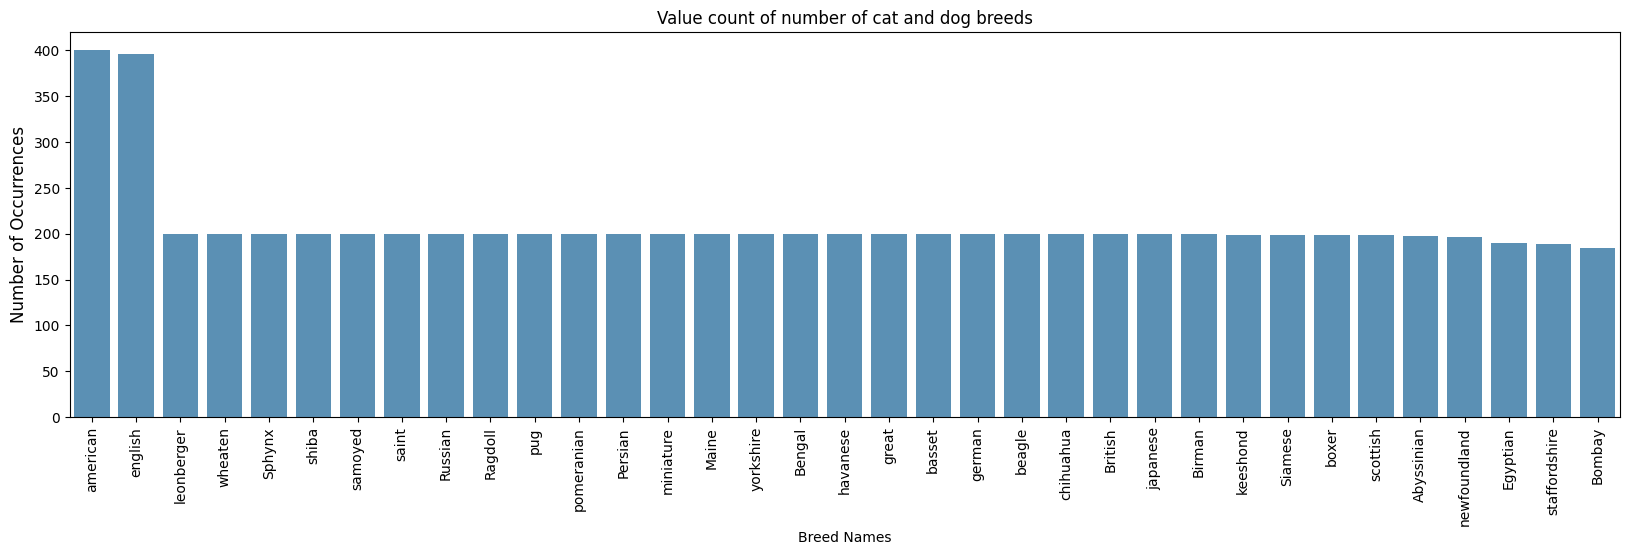

In [ ]:
breed_count(df, "cat and dog breeds")


# Separating Cats and Dogs Specie

In [17]:
df_cat = df[df['SPECIES']==1] #cat : 1
df_dog = df[df['SPECIES']==2] #dog : 2
print("Number of samples in df_cat ",df_cat.shape[0])
print("Number of samples in df_dog ",df_dog.shape[0])

Number of samples in df_cat  2371
Number of samples in df_dog  4978


# Cat Species

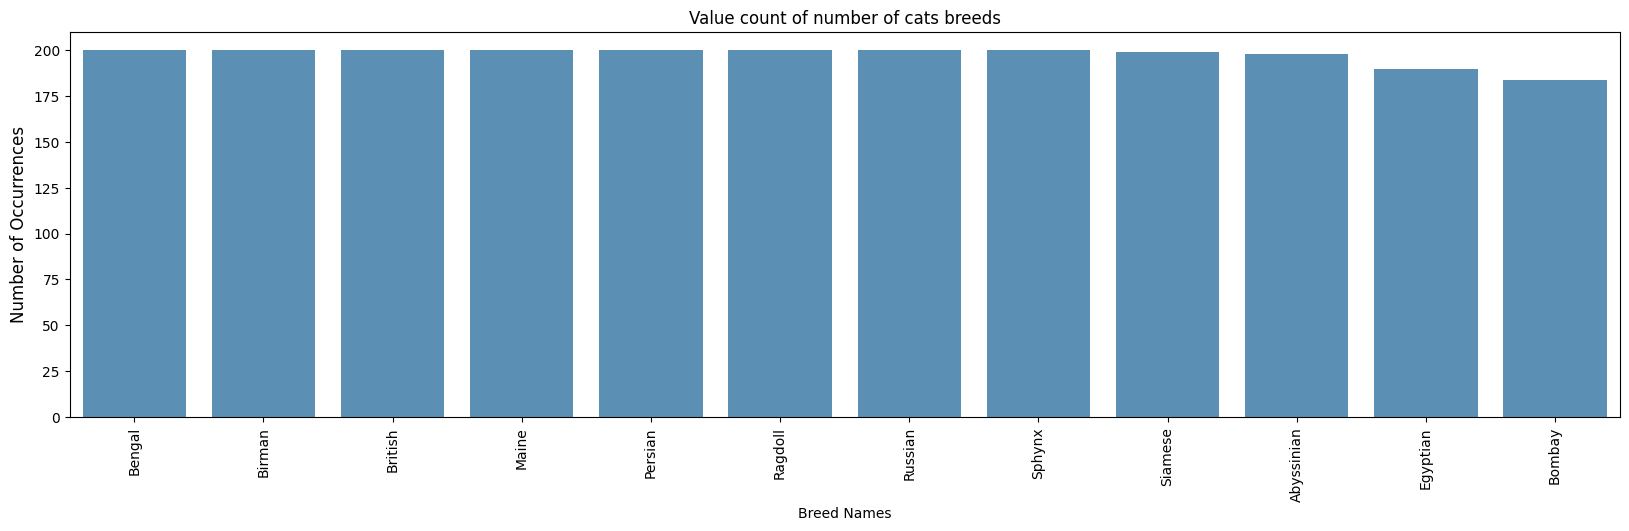

In [ ]:
breed_count(df_cat, "cats breeds")

# Dog Species

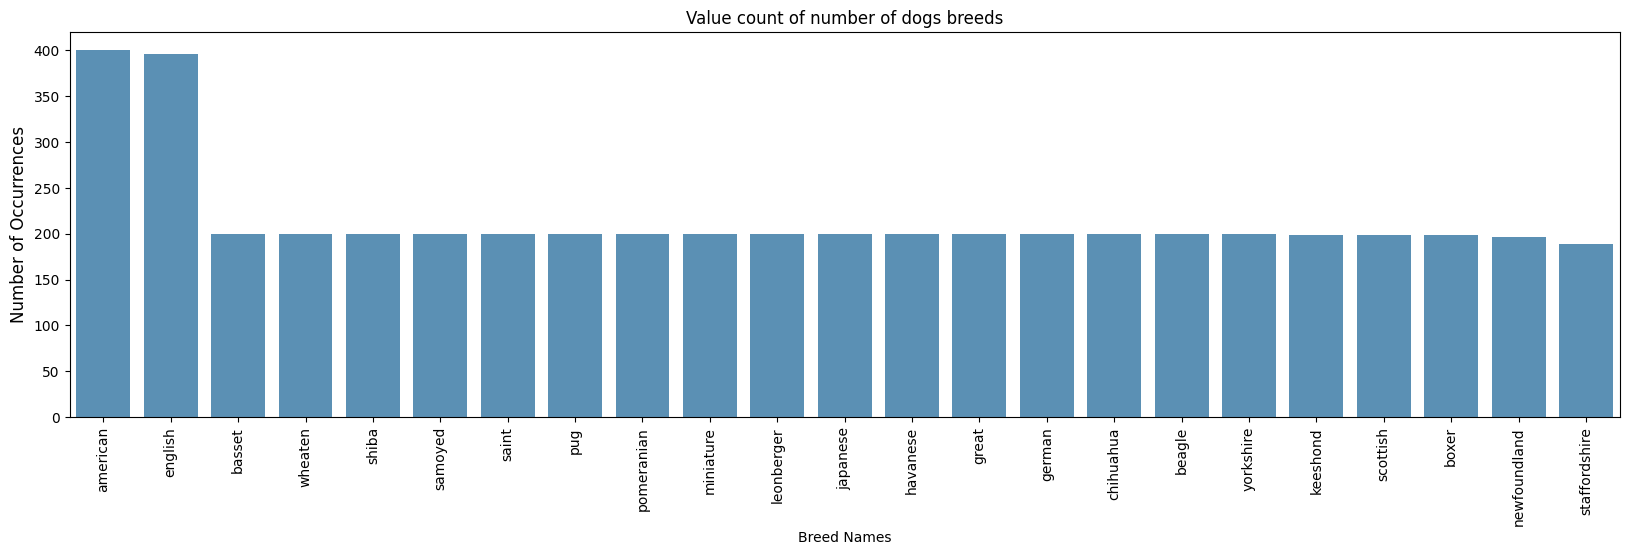

In [ ]:
breed_count(df_dog, "dogs breeds")

# **Process Image**

In [18]:
def process(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (250,250))
    img = tf.keras.applications.mobilenet.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

# Read image
def get_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


# **Visualize Samples**

In [ ]:
pwd

'/content'

In [19]:
def visualize_samples(datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)

    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    filepaths = "/content/images/images/" + filepaths

    images = filepaths.apply(get_image).reset_index(drop=True)
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(labels[sample_index])
            ax[i,j].set_axis_off()
    plt.show()

# Visualize Classification

In [20]:
def visualize_classifications(model, datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)

    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    filepaths = "/content/images/images/" + filepaths
#     print(filepaths[0])
    images = filepaths.apply(get_image).reset_index(drop=True)
    processed_images = np.vstack(images.apply(process).to_numpy()[:])

    y_pred = classes[np.argmax(model.predict(processed_images, verbose=0), axis=1)]
    y_true = labels

    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)

    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(f"Y true({y_true[sample_index]}) | Y pred ({y_pred[sample_index]})")
            ax[i,j].set_axis_off()
    plt.show()

# Data Augmentation


In [21]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    validation_split=0.2,
                                    rotation_range=90,
                                    width_shift_range=0.2,
                                   height_shift_range=0.2
                                  )


validation_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.2)

In [22]:
def datagen_flow_dataframe(df,train_datagen,validation_datagen):

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/content/images/images',
        x_col="image",
        y_col='classname',
        target_size=IMG_SHAPE,
        batch_size=128,
        class_mode="categorical",
        subset='training'
)

    valid_gen_flow = validation_datagen.flow_from_dataframe(
            dataframe=df,
            directory='/content/images/images',
            x_col='image',
            y_col='classname',
            target_size=IMG_SHAPE,
            batch_size=128,
            class_mode="categorical",
            subset='validation', shuffle=False)

    return train_gen_flow, valid_gen_flow


# Cat Generator

In [23]:
train_gen_flow_cat, valid_gen_flow_cat = datagen_flow_dataframe(df_cat,train_datagen,validation_datagen)


Found 1897 validated image filenames belonging to 12 classes.
Found 474 validated image filenames belonging to 12 classes.


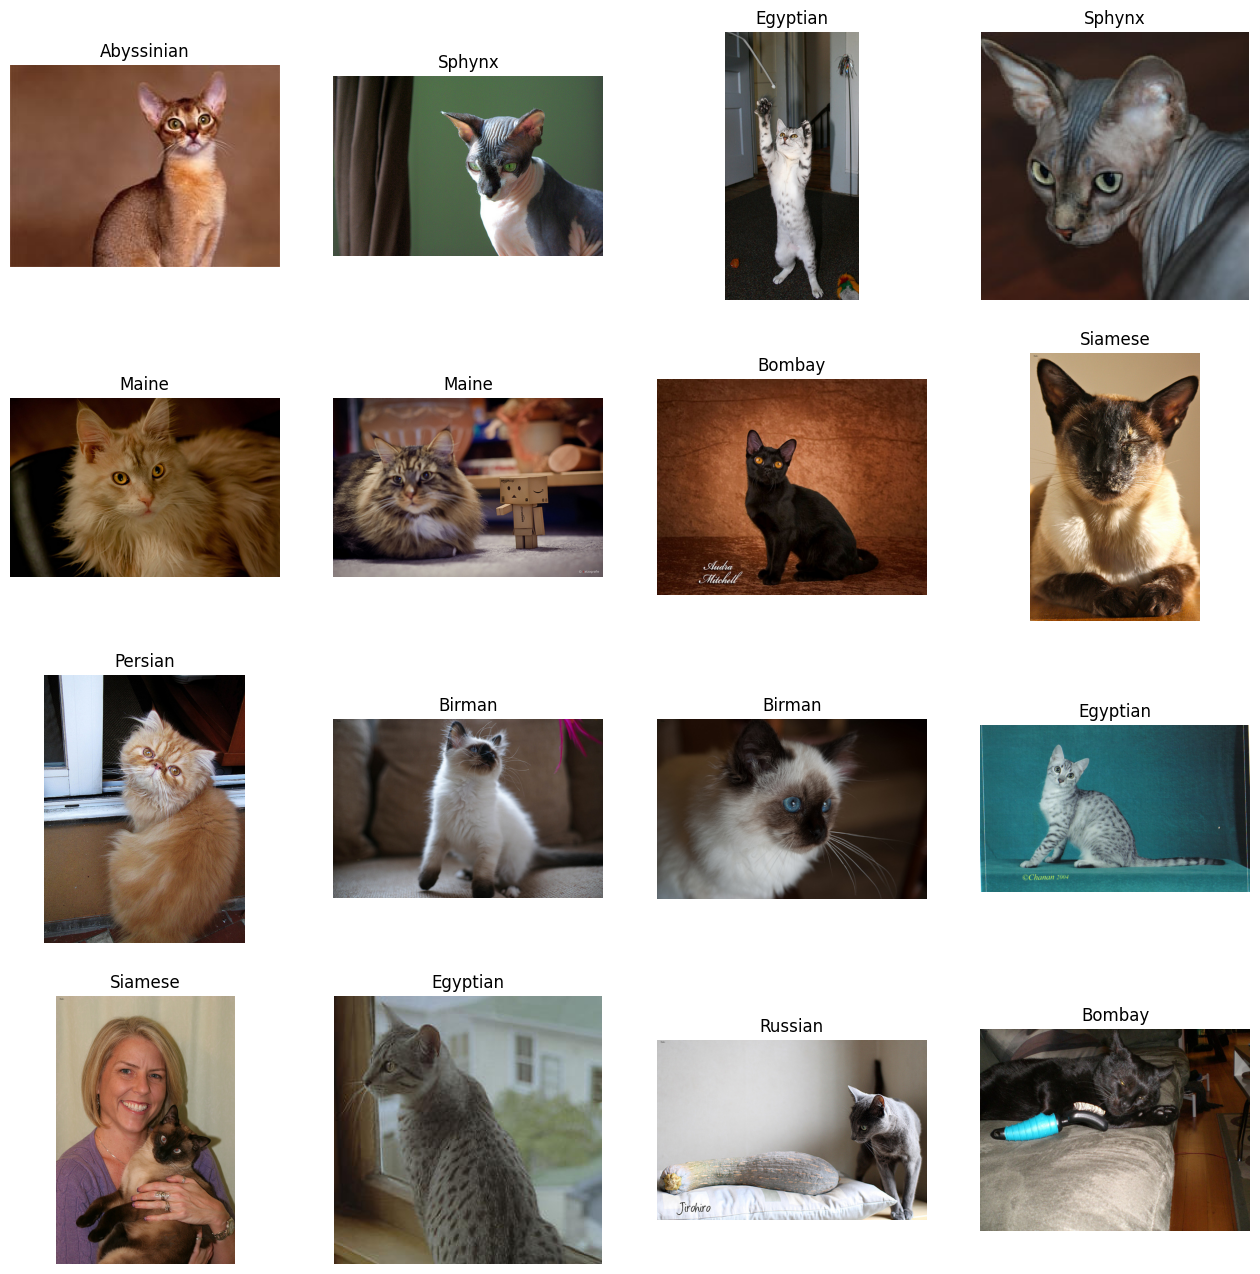

In [ ]:
visualize_samples(train_gen_flow_cat)

# Dog Generator

In [24]:
train_gen_flow_dog, valid_gen_flow_dog = datagen_flow_dataframe(df_dog,train_datagen,validation_datagen)

Found 3983 validated image filenames belonging to 23 classes.
Found 995 validated image filenames belonging to 23 classes.


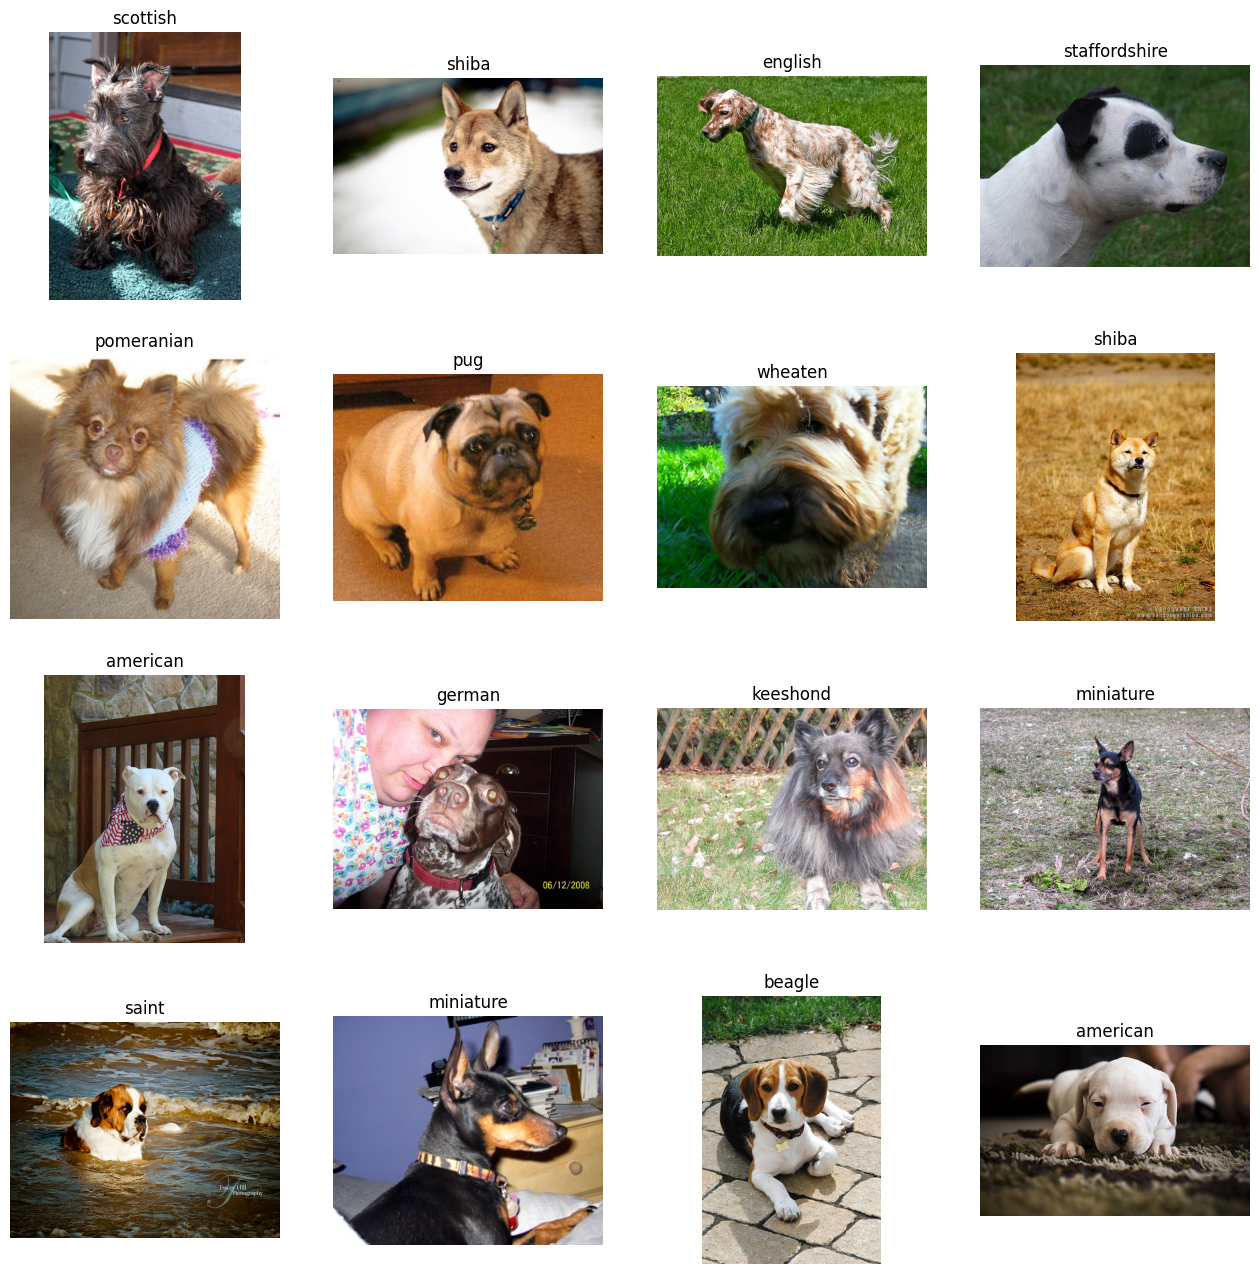

In [ ]:
visualize_samples(train_gen_flow_dog)

# Model Training

In [25]:
def train_model(model, train_generator, validation_generator, epochs, name):

    path_cp = name + '_weights.keras'
    rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 4, verbose = 1,
                                min_delta = 1e-4, min_lr = 1e-4, mode = 'min', cooldown=1)

    ckp = ModelCheckpoint(path_cp,monitor = 'val_loss',
                      verbose = 1, save_best_only = True, mode = 'min')

    es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 7,mode = 'min', restore_best_weights = True, verbose = 1)

    # Fitting the model
    history = model.fit(train_generator,
                      epochs = epochs,
                      validation_data = validation_generator,
                      verbose = 1,
                      callbacks = [rlr,es,ckp])
    return history

# Cat Model Classifier

In [26]:
pretrainedModel_cat = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE_GN,
     include_top=False,
     weights='imagenet',
     pooling='avg'
)
pretrainedModel_cat.trainable = False

inputs = pretrainedModel_cat.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrainedModel_cat.output)
x = tf.keras.layers.Dense(64, activation='relu')(x)

outputs = tf.keras.layers.Dense(12, activation='softmax')(x)

model_1 = tf.keras.Model(inputs=inputs, outputs=outputs)
model_1.compile(loss='categorical_crossentropy',optimizer=tf.optimizers.Adam(learning_rate=0.01), metrics=['acc'])

model_1.summary()


<ipython-input-26-a5c88637bb0a>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrainedModel_cat = tf.keras.applications.MobileNetV2(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 250, 250, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 125, 125, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 125, 125, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 125, 125, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 125, 125, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 125, 125, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 125, 125, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 125, 125, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 125, 125, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 125, 125, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 125, 125, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 125, 125, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 127, 127, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 63, 63, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,430,988 (9.27 MB)

 Trainable params: 173,004 (675.80 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Fitting Model

In [30]:
train_history = train_model(model_1, train_gen_flow_cat, valid_gen_flow_cat, epochs = 50,name="cat")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - acc: 0.2370 - loss: 3.0475
Epoch 1: val_loss improved from inf to 1.05031, saving model to cat_weights.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 223s 13s/step - acc: 0.2455 - loss: 3.0003 - val_acc: 0.7110 - val_loss: 1.0503 - learning_rate: 0.0100
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - acc: 0.6534 - loss: 0.9693
Epoch 2: val_loss improved from 1.05031 to 0.73608, saving model to cat_weights.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 210s 13s/step - acc: 0.6553 - loss: 0.9643 - val_acc: 0.7574 - val_loss: 0.7361 - learning_rate: 0.0100
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - acc: 0.7268 - loss: 0.7787
Epoch 3: val_loss did not improve from 0.73608
15/15 ━━━━━━━━━━━━━━━━━━━━ 256s 12s/step - acc: 0.7272 - loss: 0.7770 - val_acc: 0.7089 - val_loss: 0.7650 - learning_rate: 0.0100
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - acc: 0.7485 - loss: 0.7058 
Epoch 4: val_loss improved from 0.73608 to 0.61517, saving model to cat_weights.keras


In [31]:
#test data
model_1.evaluate(valid_gen_flow_cat)

4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 9s/step - acc: 0.8568 - loss: 0.3839


[0.3878529667854309, 0.850210964679718]

# Saving Model

In [32]:
tf.keras.models.save_model(model_1,"cat_model.keras")

# Saving History

In [33]:
import os
print(os.path.exists('cat_history.pkl'))


True


In [34]:
import pickle
with open('cat_history.pkl', 'wb') as file_pi:
    pickle.dump(train_history.history, file_pi)

#loading the history
with open('cat_history.pkl', "rb") as file_pi:
    history = pickle.load(file_pi)

# List Data in History

dict_keys(['acc', 'loss', 'val_acc', 'val_loss', 'learning_rate'])


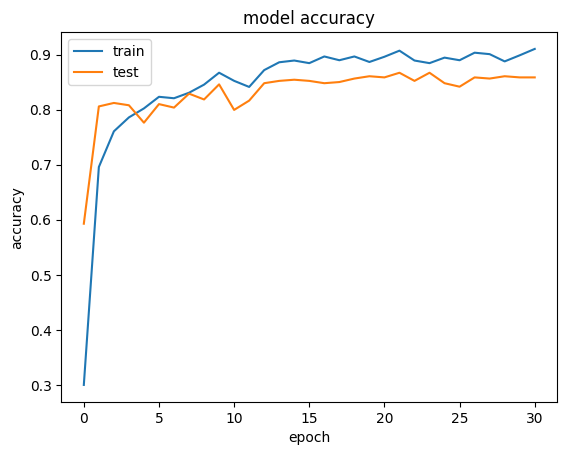

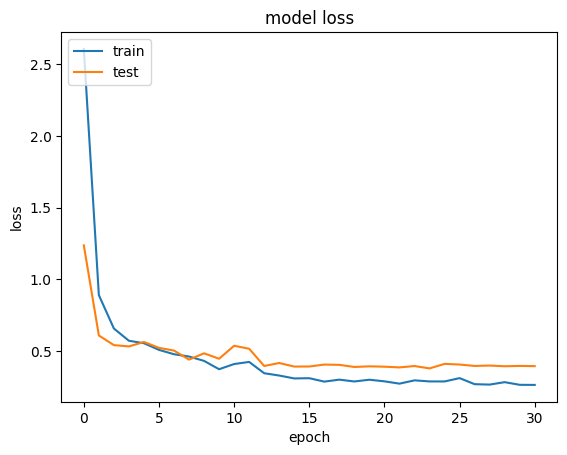

In [ ]:
print(history.keys())
# summarize history for accuracy
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')




plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

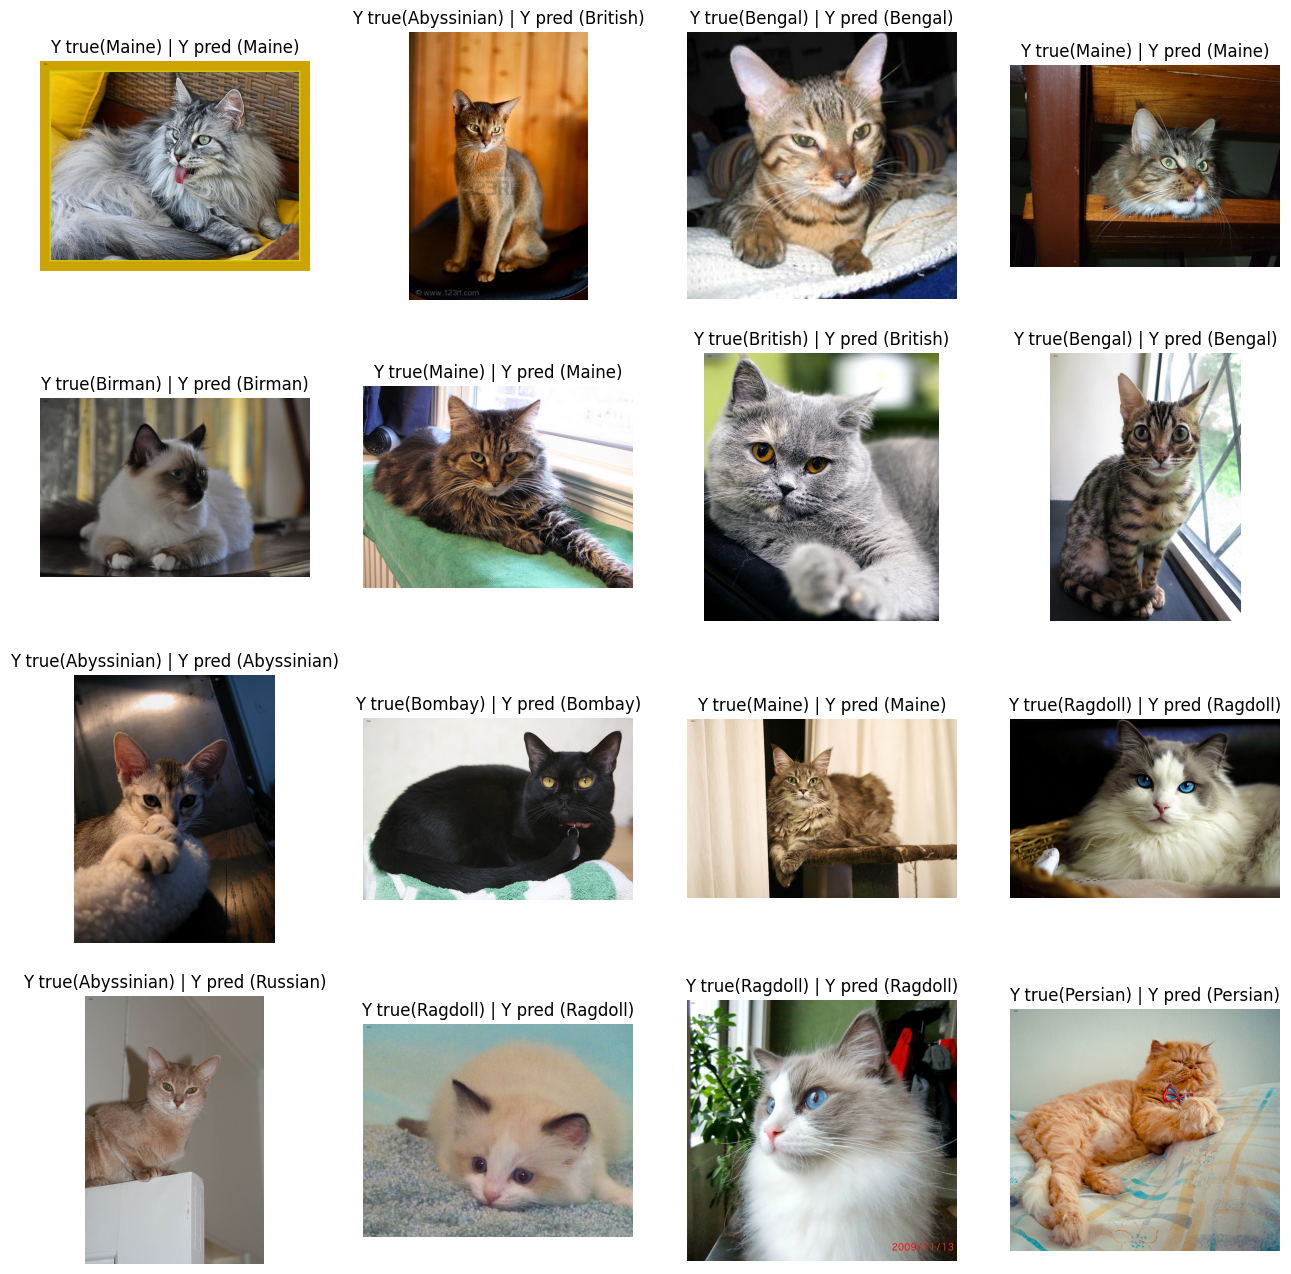

In [ ]:
visualize_classifications(model_1, valid_gen_flow_cat)


In [35]:
class_names = list(valid_gen_flow_cat.class_indices.keys())
class_names

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British',
 'Egyptian',
 'Maine',
 'Persian',
 'Ragdoll',
 'Russian',
 'Siamese',
 'Sphynx']

In [36]:
#Predicted label
y_pred = model_1.predict(valid_gen_flow_cat)
y_pred_label = np.argmax(y_pred,axis=1)


#true labels
y_test = valid_gen_flow_cat.classes

4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 10s/step


# Classification Report

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

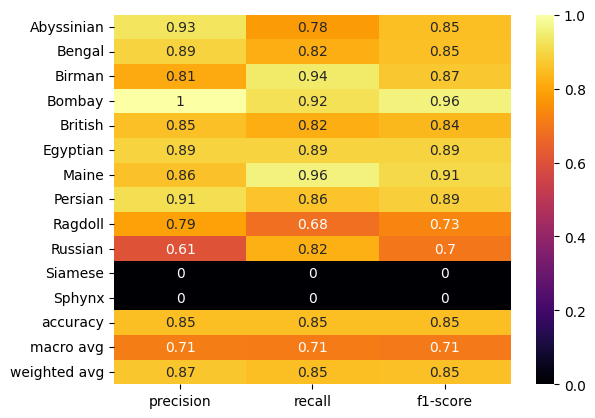

In [37]:
# Assuming y_test, y_pred_label, and class_names are defined appropriately

# Check unique classes in y_test and y_pred_label
unique_classes = sorted(set(y_test).union(y_pred_label))

# Ensure class_names matches the unique_classes
class_names = [class_names[i] for i in unique_classes]

# Generate classification report
class_report = classification_report(y_test, y_pred_label, labels=unique_classes, target_names=class_names, output_dict=True)

# Plot the heatmap
sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, annot=True, cmap='inferno')

# Confusion Matrix

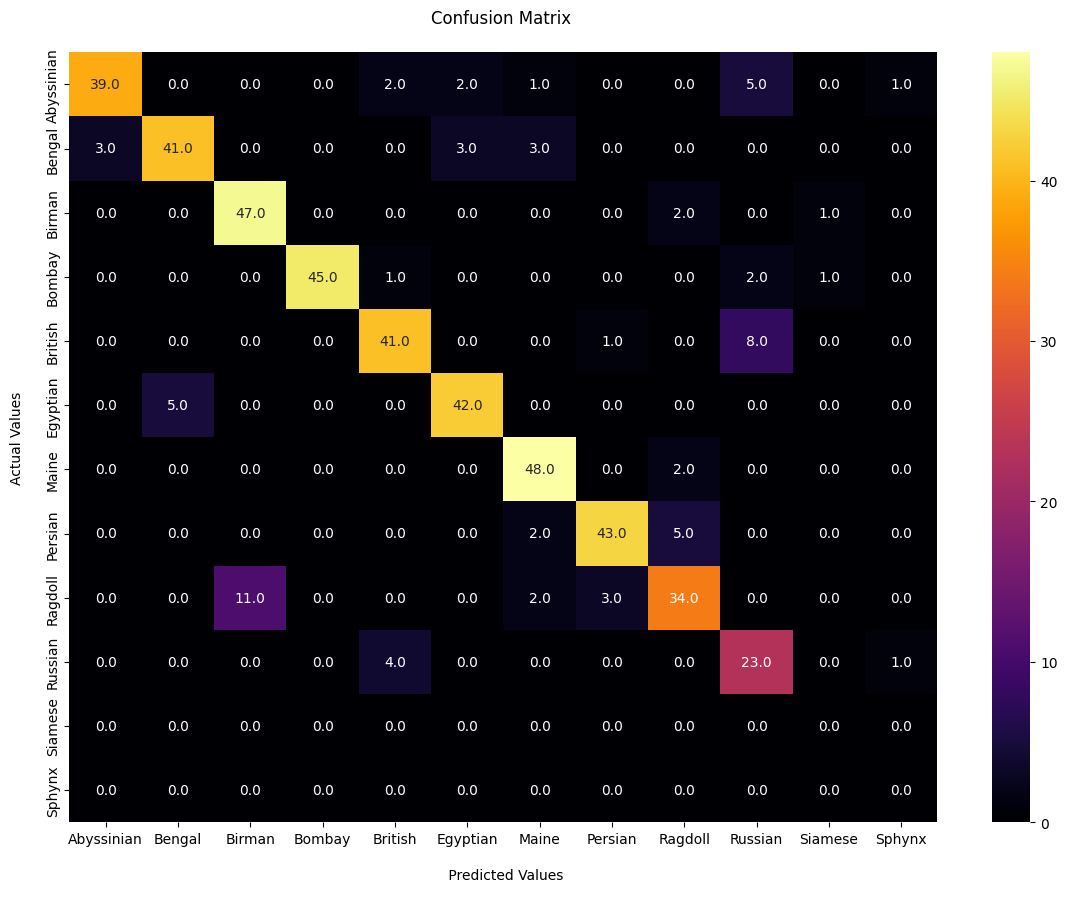

In [38]:
conf_matrix = confusion_matrix(y_test, y_pred_label)
plt.figure(figsize=(14,10))
fx=sns.heatmap(confusion_matrix(y_test,y_pred_label), annot=True, fmt=".1f",cmap="inferno")
fx.set_title('Confusion Matrix \n')
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n')
fx.xaxis.set_ticklabels(class_names)
fx.yaxis.set_ticklabels(class_names)
plt.show()

# Dog Classifier

In [39]:
pretrainedModel_dog = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE_GN,
     include_top=False,
     weights='imagenet',
     pooling='avg'
)
pretrainedModel_dog.trainable = False

inputs = pretrainedModel_dog.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrainedModel_dog.output)
x = tf.keras.layers.Dense(64, activation='relu')(x)

outputs = tf.keras.layers.Dense(23, activation='softmax')(x)

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)
model_2.compile(loss='categorical_crossentropy',optimizer=tf.optimizers.Adam(learning_rate=0.01), metrics=['acc'])

model_2.summary()

<ipython-input-39-7af8bec34f37>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrainedModel_dog = tf.keras.applications.MobileNetV2(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 250, 250, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 125, 125, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 125, 125, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 125, 125, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 125, 125, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 125, 125, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 125, 125, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 125, 125, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 125, 125, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 125, 125, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 125, 125, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 125, 125, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 127, 127, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 63, 63, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,431,703 (9.28 MB)

 Trainable params: 173,719 (678.59 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [40]:
train_history_2 = train_model(model_2, train_gen_flow_dog, valid_gen_flow_dog, epochs = 50,name="dog")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - acc: 0.2499 - loss: 2.9450 
Epoch 1: val_loss improved from inf to 0.71799, saving model to dog_weights.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 467s 14s/step - acc: 0.2549 - loss: 2.9202 - val_acc: 0.8020 - val_loss: 0.7180 - learning_rate: 0.0100
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - acc: 0.6667 - loss: 1.0419 
Epoch 2: val_loss improved from 0.71799 to 0.48698, saving model to dog_weights.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 438s 13s/step - acc: 0.6675 - loss: 1.0393 - val_acc: 0.8663 - val_loss: 0.4870 - learning_rate: 0.0100
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - acc: 0.7529 - loss: 0.7929 
Epoch 3: val_loss improved from 0.48698 to 0.41697, saving model to dog_weights.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 502s 15s/step - acc: 0.7527 - loss: 0.7929 - val_acc: 0.8814 - val_loss: 0.4170 - learning_rate: 0.0100
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - acc: 0.7647 - loss: 0.7296 
Epoch 4: val_loss did not improve from 0.416

KeyboardInterrupt: 

# Generators


In [ ]:
train_ds=keras.utils.image_dataset_from_directory(
    directory='/content/images',
    # labels=None,
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,

)

Found 7390 files belonging to 1 classes.
